In [1]:
import os, sys
import importlib
import torch

import numpy as np

from utils import load_torch, load

In [2]:
importlib.reload(load_torch)

data_folder = "data/simplified/"
access_file_generator = map(lambda x : data_folder + x + '.csv', load.classes)
trainGenerator = load_torch.ImageLoader(load.classes_1, data_folder)

In [3]:
gen = trainGenerator.__iter__()

In [4]:
%matplotlib inline
X, y = next(gen)
print('X.shape:', X.shape)
print('y.shape:', y.shape)

X.shape: torch.Size([16, 1, 32, 32])
y.shape: torch.Size([16])


# Building PyTorch CNN Model

In [7]:
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as ag
import torch.optim as optim


class VanillaDoodle(nn.Module):
    # Here we define our network structure
    def __init__(self, cdim=8):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 3).double() 
        self.conv2 = nn.Conv2d(6,16, 3).double()
        self.conv3 = nn.Conv2d(16,32,3).double()
        self.conv4 = nn.Conv2d(32,64,3).double()
        self.fc1   = nn.Linear(128,120).double()
        self.fc2   = nn.Linear(120, 84).double() 
        self.fc3   = nn.Linear(84,cdim).double()
        
    # Here we define one forward pass through the network
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))
        x = x.view(-1, int(self.num_flat_features(x)))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    # Determine the number of features in a batch of tensors
    def num_flat_features(self, x): 
        size = x.size()
        return np.prod(size[1:])


#net = VanillaDoodle(cdim=len(load.classes_1))

In [48]:
# Code derived from: https://github.com/pytorch/vision/blob/master/torchvision/models/inception.py

class BasicConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(BasicConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels, eps=0.001)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return F.relu(x, inplace=True)

class InceptionModule(nn.Module):

    def __init__(self, in_channels):
        super(InceptionModule, self).__init__()
        self.branch1x1 = BasicConv2d(in_channels, 12, kernel_size=1)

        self.branch3x3_1 = BasicConv2d(in_channels, 24, kernel_size=1)
        self.branch3x3_2a = BasicConv2d(24, 24, kernel_size=(1, 3), padding=(0, 1))
        self.branch3x3_2b = BasicConv2d(24, 24, kernel_size=(3, 1), padding=(1, 0))

        self.branch3x3dbl_1 = BasicConv2d(in_channels, 32, kernel_size=1)
        self.branch3x3dbl_2 = BasicConv2d(32, 24, kernel_size=3, padding=1)
        self.branch3x3dbl_3a = BasicConv2d(24, 24, kernel_size=(1, 3), padding=(0, 1))
        self.branch3x3dbl_3b = BasicConv2d(24, 24, kernel_size=(3, 1), padding=(1, 0))

        self.branch_pool = BasicConv2d(in_channels, 16, kernel_size=1)

    def forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch3x3 = self.branch3x3_1(x)
        branch3x3 = [
            self.branch3x3_2a(branch3x3),
            self.branch3x3_2b(branch3x3),
        ]
        branch3x3 = torch.cat(branch3x3, 1)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = [
            self.branch3x3dbl_3a(branch3x3dbl),
            self.branch3x3dbl_3b(branch3x3dbl),
        ]
        branch3x3dbl = torch.cat(branch3x3dbl, 1)

        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch3x3, branch3x3dbl, branch_pool]
        return torch.cat(outputs, 1)
    
class DoodleInception(nn.Module):
    # Here we define our network structure
    def __init__(self, cdim=8):
        super(DoodleInception, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 3).double() 
        self.mod1  = InceptionModule(6).double()
        self.conv2 = nn.Conv2d(124, 128, 3).double()
        self.fc1   = nn.Linear(512,128).double()
        self.fc2   = nn.Linear(128,cdim).double()
        
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.mod1(x)), (2, 2))  #?x124x7x7
        x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))  #?x128x2x2
        x = x.view(-1, int(self.num_flat_features(x)))
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    # Determine the number of features in a batch of tensors
    def num_flat_features(self, x): 
        size = x.size()
        return np.prod(size[1:])

In [49]:
B     = 128              # Minibatch size
T     = 10               # Number of epochs
gamma = .001             # learning rate
rho   = .9               # momentum

classes = load.classes_1
    
net = DoodleInception(cdim=len(classes))

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    net.parameters(),
    lr=gamma,
    momentum=rho
)

In [50]:
if torch.cuda.is_available():
    net = net.cuda()

accList, lossList = list(), list()
accuracy = [0]
loss_stored = []
for epoch in range(T):            
    gen = load_torch.ImageLoader(classes=load.classes_1,root_location=data_folder,read_size=32,batch_size=128)
    for i, (images, labels) in enumerate(gen):
        images = images
        labels = labels
        
        # Forward pass
        outputs = net(images)
        
        loss = criterion(outputs.cpu(), labels)
        acc = 100 * np.mean(labels.data.numpy() == outputs.cpu().data.numpy ().T.argmax(axis =0))
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        del images
        del labels
        del outputs

        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}], Loss: {:.4f}, Accuracy:{:.4f}' .format(epoch+1, T, i+1, loss.item(),acc))
            #model.save_state_dict('mytraining.pt')
        if (i+1)%100==0:
            loss_stored.append(loss.item())
            accuracy.append((0.1*acc) + (0.9*accuracy[-1]))

Epoch [1/10], Step [100], Loss: 1.9318,Accuracy:32.8125
Epoch [1/10], Step [200], Loss: 1.6854,Accuracy:46.0938
Epoch [1/10], Step [300], Loss: 1.3984,Accuracy:48.4375
Epoch [1/10], Step [400], Loss: 1.3257,Accuracy:53.1250
Epoch [1/10], Step [500], Loss: 1.1947,Accuracy:62.5000
Epoch [1/10], Step [600], Loss: 1.1183,Accuracy:67.1875
Epoch [1/10], Step [700], Loss: 1.0311,Accuracy:65.6250
Epoch [1/10], Step [800], Loss: 0.9759,Accuracy:74.2188
Epoch [1/10], Step [900], Loss: 0.9934,Accuracy:74.2188
Epoch [1/10], Step [1000], Loss: 1.1599,Accuracy:65.6250
Epoch [1/10], Step [1100], Loss: 0.7528,Accuracy:72.6562
Epoch [1/10], Step [1200], Loss: 0.7513,Accuracy:75.7812
Epoch [1/10], Step [1300], Loss: 0.8046,Accuracy:72.6562
Epoch [1/10], Step [1400], Loss: 0.7081,Accuracy:81.2500
Epoch [1/10], Step [1500], Loss: 0.6931,Accuracy:78.9062
Epoch [1/10], Step [1600], Loss: 0.6670,Accuracy:82.0312
Epoch [1/10], Step [1700], Loss: 0.8445,Accuracy:74.2188
Epoch [1/10], Step [1800], Loss: 0.6009,

Epoch [2/10], Step [7200], Loss: 0.4315,Accuracy:86.7188
Epoch [2/10], Step [7300], Loss: 0.4152,Accuracy:88.2812
Epoch [2/10], Step [7400], Loss: 0.2678,Accuracy:90.6250
Epoch [3/10], Step [100], Loss: 0.3680,Accuracy:88.2812
Epoch [3/10], Step [200], Loss: 0.4551,Accuracy:87.5000
Epoch [3/10], Step [300], Loss: 0.2864,Accuracy:89.0625
Epoch [3/10], Step [400], Loss: 0.3960,Accuracy:88.2812
Epoch [3/10], Step [500], Loss: 0.3945,Accuracy:88.2812
Epoch [3/10], Step [600], Loss: 0.4347,Accuracy:85.1562
Epoch [3/10], Step [700], Loss: 0.2459,Accuracy:92.9688
Epoch [3/10], Step [800], Loss: 0.3980,Accuracy:88.2812
Epoch [3/10], Step [900], Loss: 0.3454,Accuracy:89.8438
Epoch [3/10], Step [1000], Loss: 0.4010,Accuracy:84.3750
Epoch [3/10], Step [1100], Loss: 0.3830,Accuracy:87.5000
Epoch [3/10], Step [1200], Loss: 0.3591,Accuracy:88.2812
Epoch [3/10], Step [1300], Loss: 0.3206,Accuracy:89.8438
Epoch [3/10], Step [1400], Loss: 0.3253,Accuracy:91.4062
Epoch [3/10], Step [1500], Loss: 0.3426,

Epoch [4/10], Step [6900], Loss: 0.3148,Accuracy:86.7188
Epoch [4/10], Step [7000], Loss: 0.4044,Accuracy:89.0625
Epoch [4/10], Step [7100], Loss: 0.3241,Accuracy:89.8438
Epoch [4/10], Step [7200], Loss: 0.4329,Accuracy:85.1562
Epoch [4/10], Step [7300], Loss: 0.3195,Accuracy:89.0625
Epoch [4/10], Step [7400], Loss: 0.3818,Accuracy:89.0625
Epoch [5/10], Step [100], Loss: 0.2387,Accuracy:91.4062
Epoch [5/10], Step [200], Loss: 0.3174,Accuracy:90.6250
Epoch [5/10], Step [300], Loss: 0.1796,Accuracy:96.0938
Epoch [5/10], Step [400], Loss: 0.3414,Accuracy:89.8438
Epoch [5/10], Step [500], Loss: 0.2965,Accuracy:89.8438
Epoch [5/10], Step [600], Loss: 0.2649,Accuracy:92.1875
Epoch [5/10], Step [700], Loss: 0.1911,Accuracy:94.5312
Epoch [5/10], Step [800], Loss: 0.4359,Accuracy:85.1562
Epoch [5/10], Step [900], Loss: 0.3513,Accuracy:87.5000
Epoch [5/10], Step [1000], Loss: 0.3454,Accuracy:89.0625
Epoch [5/10], Step [1100], Loss: 0.2609,Accuracy:90.6250
Epoch [5/10], Step [1200], Loss: 0.3312,

Epoch [6/10], Step [6600], Loss: 0.2300,Accuracy:92.9688
Epoch [6/10], Step [6700], Loss: 0.3118,Accuracy:92.1875
Epoch [6/10], Step [6800], Loss: 0.2251,Accuracy:91.4062
Epoch [6/10], Step [6900], Loss: 0.3238,Accuracy:90.6250
Epoch [6/10], Step [7000], Loss: 0.3738,Accuracy:87.5000
Epoch [6/10], Step [7100], Loss: 0.2998,Accuracy:90.6250
Epoch [6/10], Step [7200], Loss: 0.3268,Accuracy:89.0625
Epoch [6/10], Step [7300], Loss: 0.4104,Accuracy:88.2812
Epoch [6/10], Step [7400], Loss: 0.3070,Accuracy:90.6250
Epoch [7/10], Step [100], Loss: 0.2421,Accuracy:89.0625
Epoch [7/10], Step [200], Loss: 0.3233,Accuracy:91.4062
Epoch [7/10], Step [300], Loss: 0.3292,Accuracy:91.4062
Epoch [7/10], Step [400], Loss: 0.2312,Accuracy:92.9688
Epoch [7/10], Step [500], Loss: 0.4098,Accuracy:85.9375
Epoch [7/10], Step [600], Loss: 0.2627,Accuracy:94.5312
Epoch [7/10], Step [700], Loss: 0.2213,Accuracy:93.7500
Epoch [7/10], Step [800], Loss: 0.3542,Accuracy:88.2812
Epoch [7/10], Step [900], Loss: 0.3336,

Epoch [8/10], Step [6300], Loss: 0.3146,Accuracy:89.8438
Epoch [8/10], Step [6400], Loss: 0.1898,Accuracy:92.1875
Epoch [8/10], Step [6500], Loss: 0.3714,Accuracy:88.2812
Epoch [8/10], Step [6600], Loss: 0.2080,Accuracy:93.7500
Epoch [8/10], Step [6700], Loss: 0.2520,Accuracy:92.1875
Epoch [8/10], Step [6800], Loss: 0.1263,Accuracy:95.3125
Epoch [8/10], Step [6900], Loss: 0.2734,Accuracy:91.4062
Epoch [8/10], Step [7000], Loss: 0.3724,Accuracy:89.0625
Epoch [8/10], Step [7100], Loss: 0.3835,Accuracy:88.2812
Epoch [8/10], Step [7200], Loss: 0.2490,Accuracy:91.4062
Epoch [8/10], Step [7300], Loss: 0.4463,Accuracy:89.8438
Epoch [8/10], Step [7400], Loss: 0.2402,Accuracy:94.5312
Epoch [9/10], Step [100], Loss: 0.2605,Accuracy:90.6250
Epoch [9/10], Step [200], Loss: 0.3136,Accuracy:92.1875
Epoch [9/10], Step [300], Loss: 0.2776,Accuracy:89.0625
Epoch [9/10], Step [400], Loss: 0.3507,Accuracy:89.0625
Epoch [9/10], Step [500], Loss: 0.2789,Accuracy:89.8438
Epoch [9/10], Step [600], Loss: 0.25

Epoch [10/10], Step [5900], Loss: 0.1954,Accuracy:93.7500
Epoch [10/10], Step [6000], Loss: 0.3665,Accuracy:89.0625
Epoch [10/10], Step [6100], Loss: 0.2744,Accuracy:90.6250
Epoch [10/10], Step [6200], Loss: 0.2018,Accuracy:96.0938
Epoch [10/10], Step [6300], Loss: 0.2066,Accuracy:94.5312
Epoch [10/10], Step [6400], Loss: 0.2439,Accuracy:92.1875
Epoch [10/10], Step [6500], Loss: 0.2774,Accuracy:90.6250
Epoch [10/10], Step [6600], Loss: 0.1740,Accuracy:94.5312
Epoch [10/10], Step [6700], Loss: 0.2121,Accuracy:92.1875
Epoch [10/10], Step [6800], Loss: 0.1676,Accuracy:92.1875
Epoch [10/10], Step [6900], Loss: 0.2449,Accuracy:89.0625
Epoch [10/10], Step [7000], Loss: 0.2433,Accuracy:92.1875
Epoch [10/10], Step [7100], Loss: 0.2396,Accuracy:92.9688
Epoch [10/10], Step [7200], Loss: 0.3648,Accuracy:89.0625
Epoch [10/10], Step [7300], Loss: 0.4411,Accuracy:88.2812
Epoch [10/10], Step [7400], Loss: 0.3324,Accuracy:90.6250


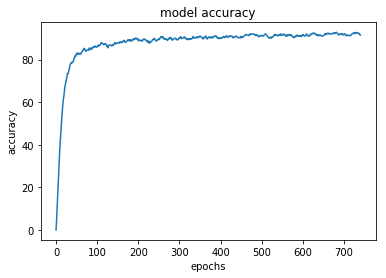

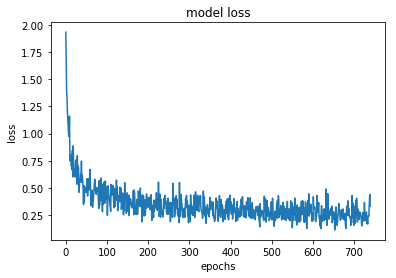

In [59]:
import matplotlib.pyplot as plt

plt.plot(accuracy)
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.title("model accuracy")
plt.savefig("doodle-inception-8classes-acc.png")
plt.show()
plt.close()

plt.plot(loss_stored)
plt.ylabel("loss")
plt.xlabel("epochs")
plt.title("model loss")
plt.savefig("doodle-inception-8classes-loss.png")
plt.show()
plt.close()